Плужникова Анастасия Дмитриевна, S4101

In [ ]:
! pip install python-graphblas[default]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 7.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread
import timeit
import random

# Реализация функций и проверка корректности (п 1-3)

In [ ]:
def MSBFS_Levels(A, sources):
  n = A.nrows
  result = gb.Matrix('int64', len(sources), n)
  f = gb.Matrix(bool, len(sources), n)
  for i, source in enumerate(sources):
        f[ i, source] = True
  level = 0
  while f.nvals > 0:
        result(mask=f.V) << level
        f(~result.S, replace=True) << f.mxm(A, semiring.lor_land)
        level += 1
  for i in range(result.nrows):
        levels = []
        for j in range(result.ncols):
            levels.append(result[i, j].value)
        print(f'Вершина: {sources[i]}\t Levels: { [-1 if x is None else x for x in levels] }')


In [ ]:
def MSBFS_Parents(A, sources):
  n = A.nrows
  index_ramp = gb.Matrix(dtypes.UINT64,len(sources), n)
  for i in range(len(sources)):
    index_ramp[i, :] << range(n)
  parents = gb.Matrix('int64', len(sources), n)
  f = gb.Matrix('int64', len(sources), n)
  for i, source in enumerate(sources):
        f[ i, source] = 1

  for i, source in enumerate(sources):
        parents[ i, source] = source

  while f.nvals > 0:
        #result(mask=f.V) << level
        f << index_ramp.ewise_mult(f, binary.first)
        f(~parents.S, replace=True) << f.mxm(A, semiring.min_first)
        parents(binary.plus) << f

  for i, source in enumerate(sources):
        parents[ i, source] = -1

  for i in range(parents.nrows):
        parent = []
        for j in range(parents.ncols):
            parent.append(parents[i, j].value)
        print(f'Вершина: {sources[i]}\t Parents: { [-2 if x is None else x for x in parent] }')

In [ ]:
adjacency_matrix = np.array([
    [0, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0, 0]

])

graph = gb.Matrix.from_dense(adjacency_matrix,missing_value=0)

Проверим корректность на двух матрицах

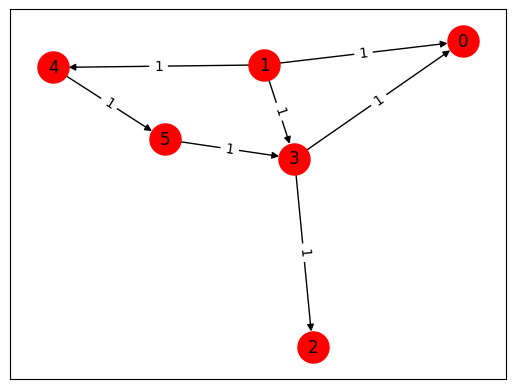

In [ ]:
gb.viz.draw(graph)

In [ ]:
MSBFS_Levels(graph, [4, 1])

Вершина: 4	 Levels: [3, -1, 3, 2, 0, 1]
Вершина: 1	 Levels: [1, 0, 2, 1, 1, 2]


In [ ]:
MSBFS_Parents(graph, [4, 1])

Вершина: 4	 Parents: [3, -2, 3, 5, -1, 4]
Вершина: 1	 Parents: [1, -1, 3, 1, 1, 4]


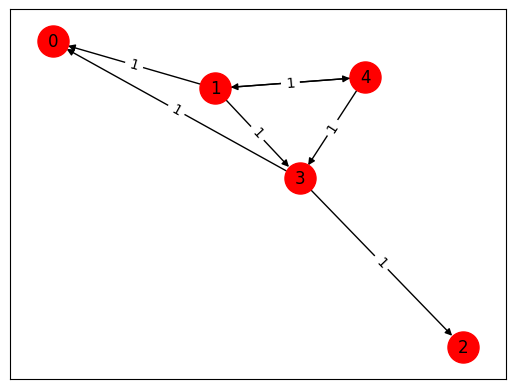

In [ ]:
adjacency_matrix2 = np.array([
    [0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1],
    [0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0]

])

graph2 = gb.Matrix.from_dense(adjacency_matrix2,missing_value=0)
gb.viz.draw(graph2)

In [ ]:
MSBFS_Levels(graph2, [4, 1])

Вершина: 4	 Levels: [2, 1, 2, 1, 0]
Вершина: 1	 Levels: [1, 0, 2, 1, 1]


In [ ]:
MSBFS_Parents(graph2, [4, 1])

Вершина: 4	 Parents: [1, 4, 3, 4, -1]
Вершина: 1	 Parents: [1, -1, 3, 1, 1]


Алгоритмы работают корректно

# Исследование на больших и сгенерированных графах (п 4)

Функция генерации случайного неориентированного графа, с заданным количеством вершин и степенью разреженности (принимает значение от 0 до 1).

In [ ]:
def generate_random_graph(num_vertices, sparsity):
    adj_matrix = np.zeros((num_vertices, num_vertices), dtype=int)
    np.fill_diagonal(adj_matrix, 0)
    # Вычисление количества рёбер в графе
    num_edges = int(num_vertices * (num_vertices - 1) * sparsity )

    edge_count = 0
    while edge_count < num_edges:
        # Выбор вершин для ребра
        vertex1 = np.random.randint(0, num_vertices)
        vertex2 = np.random.randint(0, num_vertices)

        # Проверка, что выбранные вершины не совпадают и ребро еще не существует
        if vertex1 != vertex2 and adj_matrix[vertex1][vertex2] == 0:
            adj_matrix[vertex1][vertex2] = 1
            edge_count += 1

    return gb.Matrix.from_dense(adj_matrix, missing_value=0)

In [ ]:
M1 = mmread('bcspwr10.mtx')
M2 = mmread('lshp2614.mtx')
M3 = mmread('lshp1882.mtx')
M4 = mmread('lshp2233.mtx')
M5 = mmread('dwt_2680.mtx')

Matrices = [M1, M2, M3, M4, M5]

### Исследуем зависимость времени работы реализаций от размеров графа

In [ ]:
def test_matrices_levels(Matrices):
  dictionary = {}
  for i in range(len(Matrices)):
    result = timeit.timeit(lambda:MSBFS_Levels(Matrices[i], [0, 100]), number=5)
    dictionary[Matrices[i].ncols] = result

  return dictionary

In [ ]:
def test_matrices_parents(Matrices):
  dictionary = {}
  for i in range(len(Matrices)):
    result = timeit.timeit(lambda:MSBFS_Parents(Matrices[i], [0, 100]), number=5)
    dictionary[Matrices[i].ncols] = result
  return dictionary

In [ ]:
sparsity = 0.5

Matrices_generated = [generate_random_graph(200, sparsity),
            generate_random_graph(400, sparsity),
            generate_random_graph(600, sparsity),
            generate_random_graph(800, sparsity),
            generate_random_graph(1000, sparsity)]

Графики зависимости времени работы от числа вершин

{200: 0.020834175999880244, 400: 0.039750124999955005, 600: 0.0885125100003279, 800: 0.16144606499983638, 1000: 0.2334156079996319}


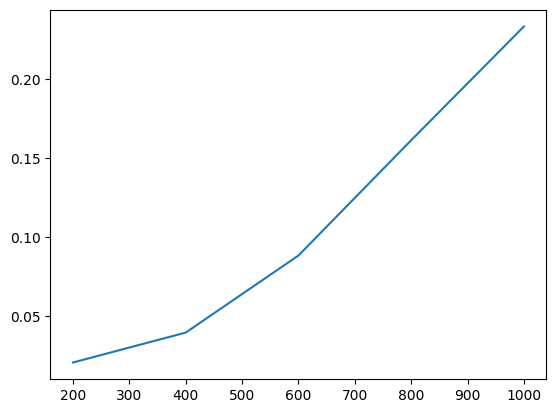

In [ ]:
result = test_matrices_levels(Matrices_generated)
print(dict(sorted(result.items())))
plt.plot(result.keys(), result.values())

{200: 0.025414597000235517, 400: 0.08273576100054925, 600: 0.1059082159999889, 800: 0.12187593599992397, 1000: 0.14737814500040258}


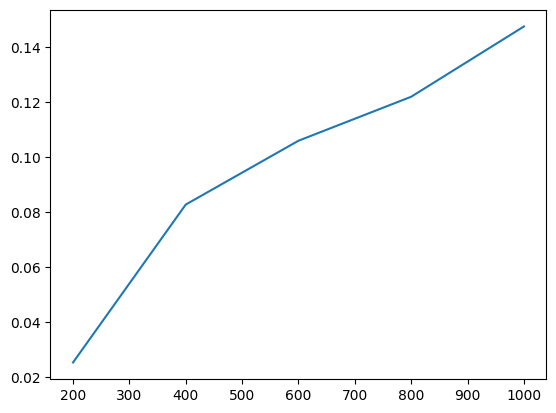

In [ ]:
result = test_matrices_parents(Matrices_generated)
print(dict(sorted(result.items())))
plt.plot(result.keys(), result.values())

С увеличением размеров графа время работы обоих алгоритмов возрастает

### Исследуем зависимость времени работы реализаций от числа стартовых вершин

In [ ]:
def test_matrices_levels_2(Matrice, source_numbers):
  dictionary = {}
  n = Matrice.ncols
  for i in source_numbers:
    a = [random.randint(1, n-1) for _ in range(i)]
    result = timeit.timeit(lambda:MSBFS_Levels(Matrice, a), number=5)
    dictionary[i] = result
  return dictionary

In [ ]:
def test_matrices_parents_2(Matrice, source_numbers):
  dictionary = {}
  n = Matrice.ncols
  for i in source_numbers:
    a = [random.randint(1, n-1) for _ in range(i)]
    result = timeit.timeit(lambda:MSBFS_Parents(Matrice, a), number=5)
    dictionary[i] = result
  return dictionary

Графики зависимости времени работы от числа стартовых вершин

{2: 0.043891561000236834, 4: 0.07737998299944593, 6: 0.1075220549992082, 8: 0.1371574459999465, 10: 0.15269608100061305}


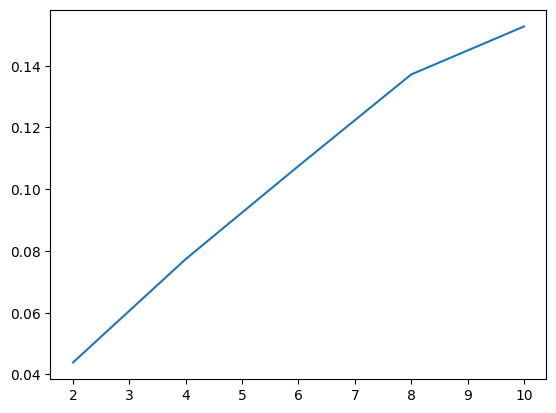

In [ ]:
result = test_matrices_levels_2(Matrices[0], [2, 4, 6, 8, 10])
print(dict(sorted(result.items())))
plt.plot(result.keys(), result.values())

{2: 0.06637625500025024, 4: 0.11212885199984157, 6: 0.1441053960006684, 8: 0.18195213899980445, 10: 0.2272938649994103}


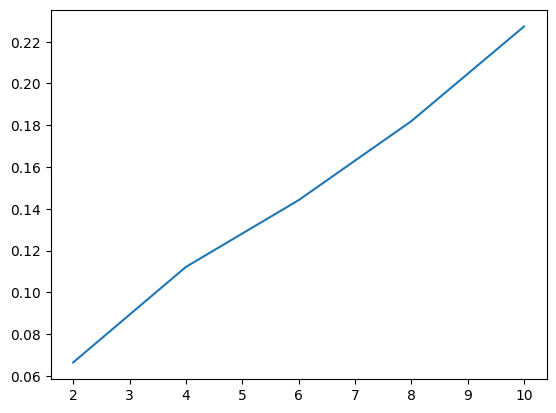

In [ ]:
result = test_matrices_parents_2(Matrices[0], [2, 4, 6, 8, 10])
print(dict(sorted(result.items())))
plt.plot(result.keys(), result.values())

С увеличением числа стартовых вершин время работы обоих алгоритмов возрастает (зависимость близка к линейной)

### Исследуем зависимость времени работы реализаций от степени разреженности

In [ ]:
def test_matrices_levels_3(Matrices, sparsity):
  dictionary = {}
  for i in range(len(Matrices)):
    result = timeit.timeit(lambda:MSBFS_Levels(Matrices[i], [0, 10]), number=5)
    dictionary[sparsity[i]] = result
  return dictionary

In [ ]:
def test_matrices_parents_3(Matrices, sparsity):
  dictionary = {}
  for i in range(len(Matrices)):
    result = timeit.timeit(lambda:MSBFS_Parents(Matrices[i], [0, 10]), number=5)
    dictionary[sparsity[i]] = result
  return dictionary

In [ ]:
num_vertices = 1000

Matrices_generated = [generate_random_graph(num_vertices, 0.2),
            generate_random_graph(num_vertices, 0.4),
            generate_random_graph(num_vertices, 0.6),
            generate_random_graph(num_vertices, 0.8),
            generate_random_graph(num_vertices, 1)]

Графики зависимости времени работы от степени разреженности

{'0.2': 0.015412363999530498, '0.4': 0.07335636900006648, '0.6': 0.07039510100003099, '0.8': 0.051193665999562654, '1': 0.0031833930006541777}


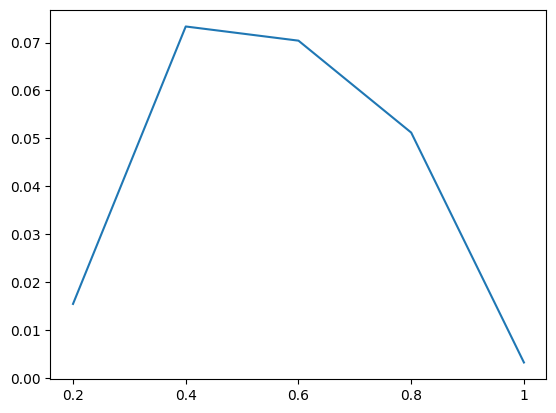

In [ ]:
result = test_matrices_levels_3(Matrices_generated, ['0.2', '0.4', '0.6', '0.8', '1'])
print(dict(sorted(result.items())))
plt.plot(result.keys(), result.values())

{'0.2': 0.013617744999464776, '0.4': 0.055258874999708496, '0.6': 0.045424302000355965, '0.8': 0.027950071999839565, '1': 0.007054667000375048}


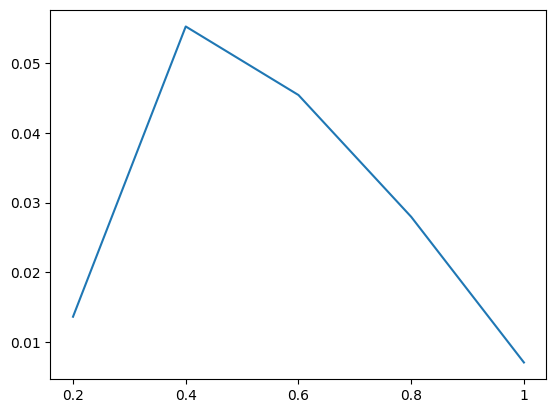

In [ ]:
result = test_matrices_parents_3(Matrices_generated, ['0.2', '0.4', '0.6', '0.8', '1'])
print(dict(sorted(result.items())))
plt.plot(result.keys(), result.values())

Можно сказать, что при степениразреженности графа, примерно равной 0.5, алгоритмы работают медленнее всего. При уменьшении или увеличении степени, время работы уменьшается





# Реализации с использованием других полуколец (п 5)

In [ ]:
def MSBFS_Levels_Any(A, sources):
  n = A.nrows
  result = gb.Matrix('int64', len(sources), n)
  f = gb.Matrix(bool, len(sources), n)
  for i, source in enumerate(sources):
        f[ i, source] = True
  level = 0
  while f.nvals > 0:
        result(mask=f.V) << level
        f(~result.S, replace=True) << f.mxm(A, semiring.any_pair)
        level += 1
  for i in range(result.nrows):
        levels = []
        for j in range(result.ncols):
            levels.append(result[i, j].value)
        print(f'Вершина: {sources[i]}\t Levels: { [-1 if x is None else x for x in levels] }')

In [ ]:
def MSBFS_Parents_Any(A, sources):
  n = A.nrows
  index_ramp = gb.Matrix(dtypes.UINT64,len(sources), n)
  for i in range(len(sources)):
    index_ramp[i, :] << range(n)
  parents = gb.Matrix('int64', len(sources), n)
  f = gb.Matrix('int64', len(sources), n)
  for i, source in enumerate(sources):
        f[ i, source] = 1

  for i, source in enumerate(sources):
        parents[ i, source] = source

  while f.nvals > 0:
        #result(mask=f.V) << level
        f << index_ramp.ewise_mult(f, binary.first)
        f(~parents.S, replace=True) << f.mxm(A, semiring.any_first)
        parents(binary.plus) << f

  for i, source in enumerate(sources):
        parents[ i, source] = -1

  for i in range(parents.nrows):
        parent = []
        for j in range(parents.ncols):
            parent.append(parents[i, j].value)
        print(f'Вершина: {sources[i]}\t Parents: { [-2 if x is None else x for x in parent] }')

Проверим на корректность с помощью тех же графов

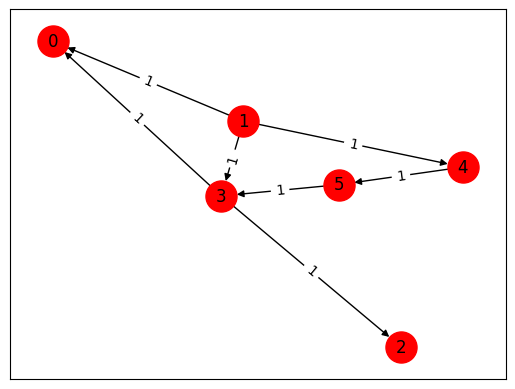

In [ ]:
adjacency_matrix = np.array([
    [0, 0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1, 0],
    [0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0, 0]

])

graph = gb.Matrix.from_dense(adjacency_matrix,missing_value=0)
gb.viz.draw(graph)

In [ ]:
MSBFS_Levels_Any(graph, [4, 1])

Вершина: 4	 Levels: [3, -1, 3, 2, 0, 1]
Вершина: 1	 Levels: [1, 0, 2, 1, 1, 2]


In [ ]:
MSBFS_Parents_Any(graph, [4, 1])

Вершина: 4	 Parents: [3, -2, 3, 5, -1, 4]
Вершина: 1	 Parents: [1, -1, 3, 1, 1, 4]


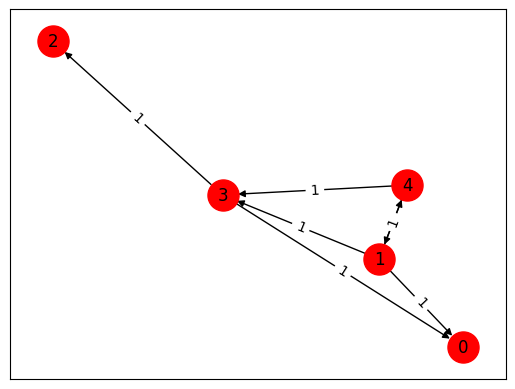

In [ ]:
adjacency_matrix2 = np.array([
    [0, 0, 0, 0, 0],
    [1, 0, 0, 1, 1],
    [0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0],
    [0, 1, 0, 1, 0]

])

graph2 = gb.Matrix.from_dense(adjacency_matrix2,missing_value=0)
gb.viz.draw(graph2)

In [ ]:
MSBFS_Levels_Any(graph2, [4, 1])

Вершина: 4	 Levels: [2, 1, 2, 1, 0]
Вершина: 1	 Levels: [1, 0, 2, 1, 1]


In [ ]:
MSBFS_Parents_Any(graph2, [4, 1])

Вершина: 4	 Parents: [3, 4, 3, 4, -1]
Вершина: 1	 Parents: [1, -1, 3, 1, 1]


Всё отрабатывает корректно.

Видим, что в этом случае список Parents от 4 вершины для 0 отличается (между 3 и 1 выбрана 3)

(Было:

Вершина: 4	 Parents: [1, 4, 3, 4, -1]


Вершина: 1	 Parents: [1, -1, 3, 1, 1])

### Исследуем скорость работы на различных графах

In [ ]:
def test_matrices_levels_4(Matrices, labels):
  alg = ['lor_land', 'any_pair']
  for i in range(len(Matrices)):
    results = []
    results.append(timeit.timeit(lambda:MSBFS_Levels(Matrices[i], [0, 100]), number=5))
    results.append(timeit.timeit(lambda:MSBFS_Levels_Any(Matrices[i], [0, 100]), number=5))
    plt.plot(alg, results, label=labels[i])

  plt.xlabel('Полукольцо')
  plt.ylabel('Время')
  plt.xticks(rotation=90)
  plt.legend()
  plt.show()

In [ ]:
def test_matrices_parents_4(Matrices, labels):
  alg = ['min_first', 'any_first']
  for i in range(len(Matrices)):
    results = []
    results.append(timeit.timeit(lambda:MSBFS_Parents(Matrices[i], [0, 100]), number=5))
    results.append(timeit.timeit(lambda:MSBFS_Parents_Any(Matrices[i], [0, 100]), number=5))
    plt.plot(alg, results, label=labels[i])

  plt.xlabel('Полукольцо')
  plt.ylabel('Время')
  plt.xticks(rotation=90)
  plt.legend()
  plt.show()

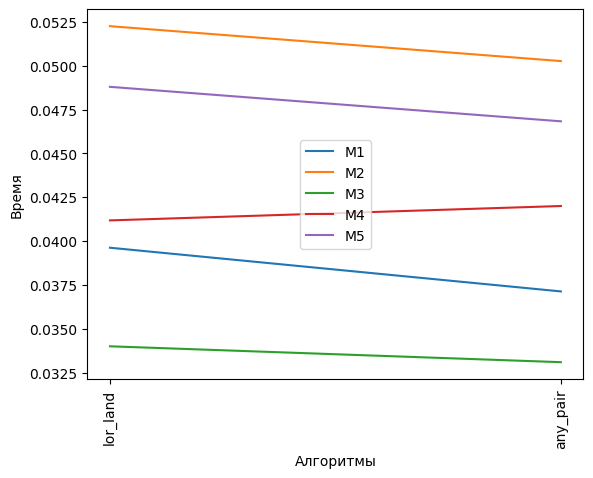

In [ ]:
test_matrices_levels_4(Matrices, ['M1', 'M2', 'M3', 'M4', 'M5'])

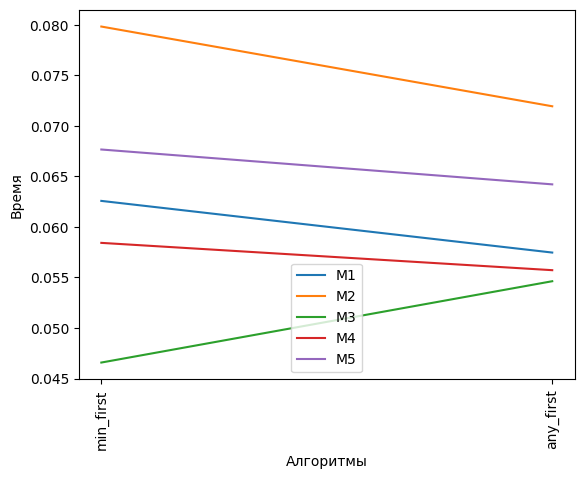

In [ ]:
test_matrices_parents_4(Matrices, ['M1', 'M2', 'M3', 'M4', 'M5'])

Скорость работы алгоритмов для разных полуколец в обоих случаях отличается незначительно. Сложно проследить зависимость.

Посмотрим также, влияет ли количество начальных вершин на разницу в скорости

In [ ]:
def test_matrices_levels_5(Matrice, labels):
  alg = ['lor_land', 'any_pair']
  n = Matrice.ncols
  for i in labels:
    a = [random.randint(1, n-1) for _ in range(i)]
    results = []
    results.append(timeit.timeit(lambda:MSBFS_Levels(Matrice, a), number=5))
    results.append(timeit.timeit(lambda:MSBFS_Levels_Any(Matrice, a), number=5))
    plt.plot(alg, results, label=i)

  plt.xlabel('Полукольцо')
  plt.ylabel('Время')
  plt.xticks(rotation=90)
  plt.legend()
  plt.show()

In [ ]:
def test_matrices_parents_5(Matrice, labels):
  alg = ['min_first', 'any_first']
  n = Matrice.ncols
  for i in labels:
    a = [random.randint(1, n-1) for _ in range(i)]
    results = []
    results.append(timeit.timeit(lambda:MSBFS_Parents(Matrice, a), number=5))
    results.append(timeit.timeit(lambda:MSBFS_Parents_Any(Matrice, a), number=5))
    plt.plot(alg, results, label=i)

  plt.xlabel('Полукольцо')
  plt.ylabel('Время')
  plt.xticks(rotation=90)
  plt.legend()
  plt.show()

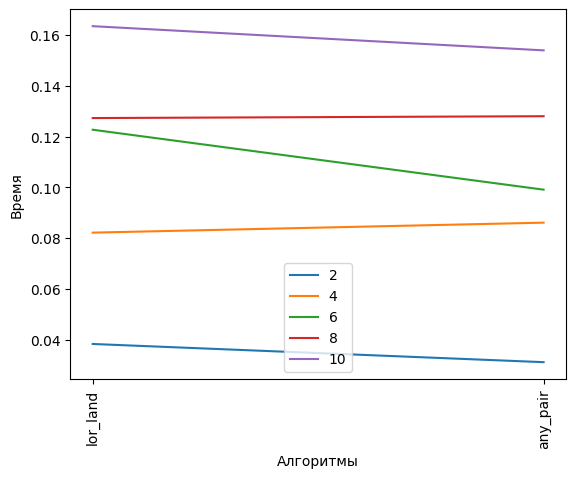

In [ ]:
test_matrices_levels_5(Matrices[0], [2, 4, 6, 8, 10])

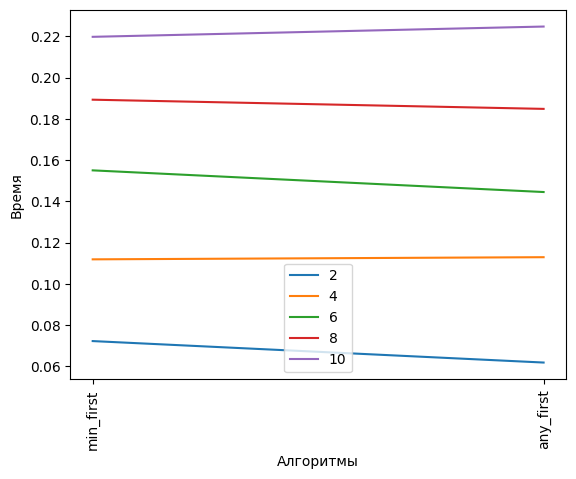

In [ ]:
test_matrices_parents_5(Matrices[0], [2, 4, 6, 8, 10])

Аналогично, скорость работы алгоритмов для разных полуколец в обоих случаях отличается незначительно. Сложно проследить зависимость.
